# Introduction to data analysis using machine learning #

## 01. The Dataset ##

by David Taylor, [www.prooffreader.com](http://www.prooffreader.com) (blog) [www.dtdata.io](http://dtdata.io) (hire me!)

For links to more material including a slideshow explaining all this stuff in further detail, please see the front page of [this GitHub repo.](https://github.com/Prooffreader/intro_machine_learning)

This is notebook 1 of 8. The next notebook is: [[02. Clustering with K-Means]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/02_Clustering_KMeans.ipynb)

Quicklinks: **[01]** [[02]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/02_Clustering_KMeans.ipynb) [[03]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/03_Clustering_OtherAlgos.ipynb) [[04]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/04_Classification_kNN.ipynb) [[05]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/05_Classification_OtherAlgos.ipynb) [[06]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/06_Classification_Decision_Trees.ipynb) [[07]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/07_Classification_Random_Forest.ipynb) [[08]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/08_Dimensionality_Reduction.ipynb)

***

The dataset is invented. I took the well-known Wines dataset from http://archive.ics.uci.edu/ml/datasets/Wine, got rid of most of the features and changed others and invented one.

The dataset is now called ``fruit``. It allows us to compare apples to oranges! (Also apples to pears, since that's the French expression).

The columns are:

* ``fruit_id``: 1-3, numeric id for:
* ``fruit_name``: orange, pear and apple, corresponding to ``fruit`` == 1, 2, and 3, respectively
* ``color_id``: 1-6, numeric id for:
* ``color_name``: blue, brown, green, orange, red, yellow, corresponding to ``color`` == 1-6, respectively.
* ``elongatednessness``: 0-1, continuous. A concept borrowed from the famous ``seeds`` dataset (which uses the inverse, compactness). If one were to take a two-dimensional image of the fruit (presumably in a random orientation) and make the smallest ellipse it would fit within, ``elongatednessness`` is the length of the long axis divided by the length of the short axis, minus 1. An infinitely long line has an infinite elongatedness, a perfect circle (or square, for that matter) has an elongatedness of zero.
* ``weight``: in grams
* ``sweetness``: in totally fictional units; I just took the (unit-unspecified) values for proline from ``Wines`` and fudged them a bit.
* ``acidity``: same note as ``sweetness``, except original column was OD280/315.

##### Waitaminute! Blue fruit? #

I added some noise to this dataset by pretending the color names were assigned manually, and a certain number of people who performed the task had different sorts of color-blindedness.

Note that, like the Wines dataset, it's easy to get near- (but, unlike Wines, not totally) perfect classification. I thought the signal-to-noise ratio should be kept relatively high (but again, not perfect) for beginners.

#### 1. Import libraries and datafile

In [3]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# I only use Python 3.4.x+, hopefully the above statement will make this notebook
# work in Python 2.7.x

import sys
print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv('fruit.csv')

fruitnames = {1: 'Orange', 2: 'Pear', 3: 'Apple'}
colors = {1: '#e09028', 2: '#55aa33', 3: '#cc3333'}
fruitlist = ['Orange', 'Pear', 'Apple']
# It's a trifle inelegant to use both a list and a dict,
# but fruitlist is zero-indexed and fruitnames is one-indexed.

df.sort_values(['sweetness', 'acidity', 'weight', 'elongatedness'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail(10)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


,fruit_id,fruit_name,color_id,color_name,elongatedness,weight,sweetness,acidity
169,1,orange,4,orange,0.08,144,3.58,1290
170,1,orange,5,red,0.11,182,3.58,1295
171,1,orange,4,orange,0.11,144,3.59,1035
172,1,orange,4,orange,0.09,143,3.63,1015
173,2,pear,6,yellow,0.47,123,3.64,380
174,2,pear,6,yellow,0.56,126,3.69,465
175,1,orange,5,red,0.11,189,3.71,780
176,1,orange,4,orange,0.19,144,3.82,845
177,1,orange,5,red,0.09,191,3.92,1065
178,1,orange,2,brown,0.15,152,4.00,1035


#### 2. Explore the dataset #

Count the instance labels:

In [2]:
# count the instance labels
for fruit in df.fruit_id.unique():
    print("{} instances of fruit #{}, {}".format(len(df[df.fruit_id == fruit]),
                                                    fruit, fruitnames[fruit]))

49 instances of fruit #3, Apple
71 instances of fruit #2, Pear
59 instances of fruit #1, Orange


Describe the four numeric features:

In [4]:
df[['elongatedness', 'weight', 'sweetness', 'acidity']].describe()

,elongatedness,weight,sweetness,acidity
count,179.000000,179.000000,179.000000,179.000000
mean,0.296369,144.340782,2.606034,745.849162
std,0.161922,19.280632,0.712020,314.332206
min,0.020000,105.000000,1.270000,278.000000
25%,0.150000,129.000000,1.925000,501.000000
50%,0.280000,143.000000,2.780000,672.000000
75%,0.430000,156.000000,3.170000,985.000000
max,0.690000,198.000000,4.000000,1680.000000


View a crosstab of colors and fruit. See introductory note if you're confused about the blue pears.

In [5]:
pd.crosstab(df.fruit_name, df.color_name)

color_name,blue,brown,green,orange,red,yellow
fruit_name,,,,,,
apple,3,1,15,0,16,14
orange,0,8,1,37,13,0
pear,2,12,9,3,2,43


View all pairwise plots of features in a scatterplot matrix:

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


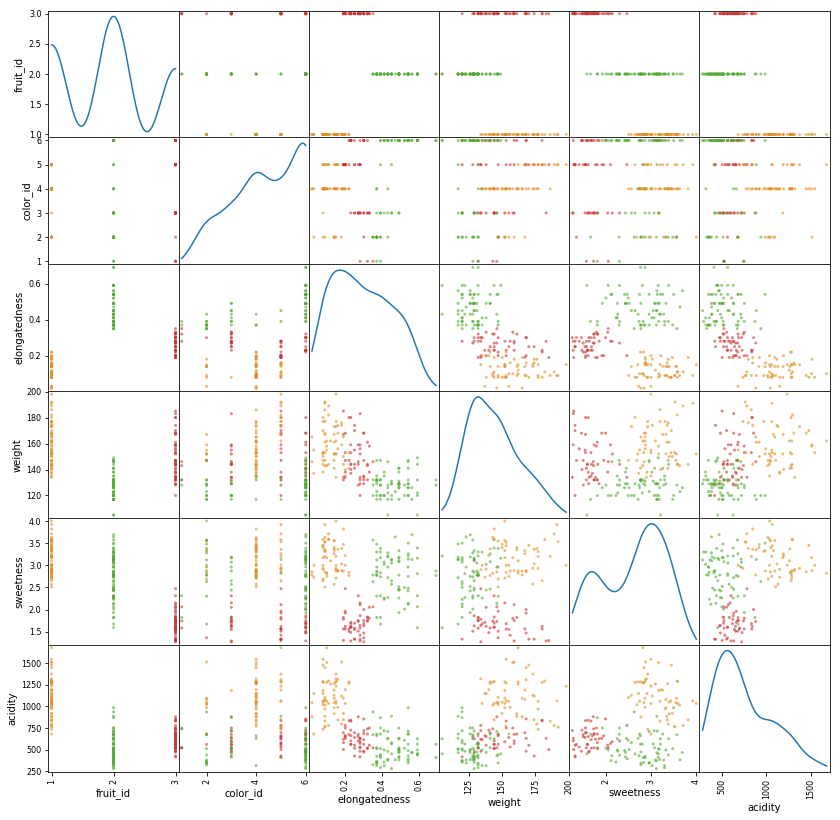

In [6]:
_ = pd.scatter_matrix(df, figsize=(14,14), diagonal='kde', alpha=0.6, color=[colors[x] for x in list(df.fruit_id)])

From the above, it appears ``sweetness`` and ``acidity`` should be a good candidate for clustering:

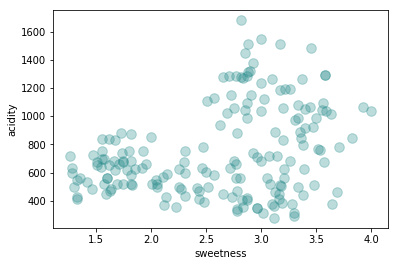

In [7]:
df.plot(kind='scatter', x='sweetness', y='acidity', color='#228888', s=92, alpha=0.3)

... but not *too* good. Also, the labels do not perfectly correspond with the clusters (see how there are green dots inside the red and orange regions?), making it a good candidate to demonstrate classification.

In [15]:
df.head(2)

,fruit_id,fruit_name,color_id,color_name,elongatedness,weight,sweetness,acidity
0,3,apple,3,green,0.30,134,1.27,720
1,3,apple,6,yellow,0.23,159,1.29,600


In [16]:
colors

{1: '#e09028', 2: '#55aa33', 3: '#cc3333'}

In [17]:
fruitnames

{1: 'Orange', 2: 'Pear', 3: 'Apple'}

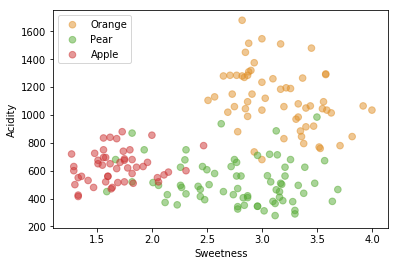

In [9]:
for i in range(3):
    plt.scatter(df[df.fruit_id == i+1].sweetness, df[df.fruit_id == i+1].acidity, 
                s=44, c=[colors[x] for x in list(df[df.fruit_id == i+1].fruit_id)], 
                alpha=0.5, label=fruitnames[i+1])
plt.xlabel('Sweetness')
plt.ylabel('Acidity')
plt.legend()
plt.show()

In [13]:
fruitnames

{1: 'Orange', 2: 'Pear', 3: 'Apple'}

To see the other continuous numeric variables, let's plot Sweetness vs. Weight.

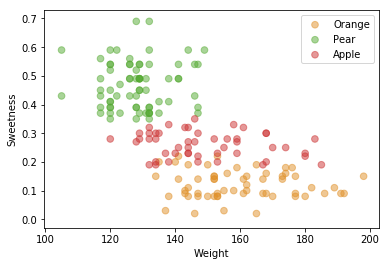

In [14]:
for i in range(3):
    plt.scatter(df[df.fruit_id == i+1].weight, df[df.fruit_id == i+1].elongatedness, 
                s=44, c=[colors[x] for x in list(df[df.fruit_id == i+1].fruit_id)], 
                alpha=0.5, label=fruitnames[i+1])
plt.xlabel('Weight')
plt.ylabel('Sweetness')
plt.legend()
plt.show()